# Result - Analysis Debugging Validation Experiment

This experiment focuses on validating the effectiveness of analysis debugging techniques. The goal is to ensure that the implemented debugging methods accurately can acheive a good recall with datamodels and be performatic. Every step of the experiment is evaluated below.

## Main Results



In [1]:
import polars as pl
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from experiments.prompt_analysis_recall.run_rag import INSTRUCTIONS
from utils.metrics.calculate_metric import calculate_agg_metric

EXPERIMENTS = ["experiment_1", "experiment_4", "experiment_54", "experiment_61", "experiment_73"]
INSTRUCTIONS = ["instruction_0", "instruction_1", "instruction_2"]
ROOT = ".."

wiki = pl.read_ipc(f"../../../../data/wiki_dump2018_nq_open/processed/wiki.feather")
gold = pl.read_ipc(f"../../../../data/nq_open_gold/processed/dev.feather")


/home/caio.rhoden/miniconda3/envs/nq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 01-10 11:16:44 [__init__.py:216] Automatically detected platform cuda.


## RAG

In [8]:
## For each experiment, calculate rouge_l metric for each questions

LOAD = True

if not LOAD:

    rag_dfs_generations = []
    for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
            questions_path = f"{ROOT}/{exp}/questions.feather"
            for file in os.listdir(f"{ROOT}/{exp}/{inst}/generations"):
                    if file.startswith("rag_"):
                        rag_dfs_generations.append(calculate_agg_metric(
                            metrics=["rouge_l"],
                            generation_path=f"{ROOT}/{exp}/{inst}/generations/{file}",
                            reference_path=questions_path    ,
                            saving_path=None            
                        )
                        .with_columns([
                            pl.lit(exp).alias("experiment"),
                            pl.lit(inst).alias("instruction")
                        ]))

    rag_dfs_generations = pl.concat(rag_dfs_generations)
    rag_dfs_generations.write_ipc(f"rag_dfs_generations.feather")        
else:
    rag_dfs_generations = pl.read_ipc(f"rag_dfs_generations.feather")


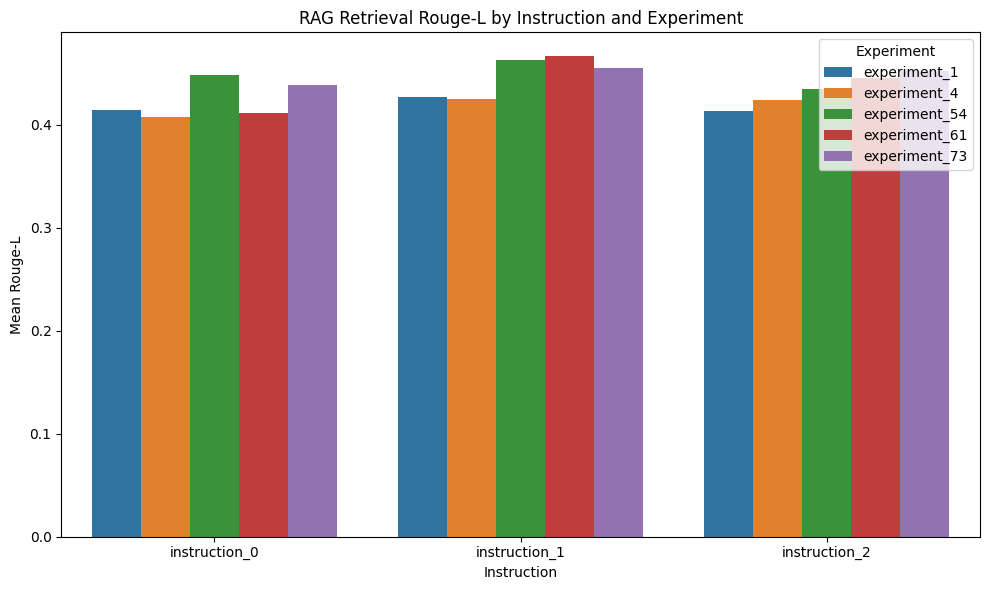

In [3]:
_rag = rag_dfs_generations.group_by(["experiment", "instruction"]).agg(pl.mean("mean")).sort(["experiment", "instruction"])

## bar plot per instruction with hue by experiment
plt.figure(figsize=(10, 6))
sns.barplot(data=_rag.to_pandas(), x="instruction", y="mean", hue="experiment")
plt.title("RAG Retrieval Rouge-L by Instruction and Experiment")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Experiment")
plt.tight_layout()
plt.show()

In [8]:
rag_dfs_generations.filter(pl.col("instruction") == "instruction_1").group_by(["experiment", "instruction"]).agg(pl.mean("mean")).sort(["experiment", "instruction"])


experiment,instruction,mean
str,str,f64
"""experiment_1""","""instruction_1""",0.427197
"""experiment_4""","""instruction_1""",0.424819
"""experiment_54""","""instruction_1""",0.462721
"""experiment_61""","""instruction_1""",0.466188
"""experiment_73""","""instruction_1""",0.455062


In [3]:

gold_counts = []

for exp in EXPERIMENTS:
    retrieval_path = f"{ROOT}/{exp}/instruction_1"
    questions_path = f"{ROOT}/{exp}/questions.feather"
    docs_to_retrieve = json.load(open(f"{retrieval_path}/retrieval/rag_retrieval_indexes.json", "r"))
    questions = pl.read_ipc(f"{questions_path}")
    count16 = 0
    count = 0
    index_pos = []
    for i in range(500):
        gold_idx = gold.filter(pl.col("idx") == questions[i]["idx"].to_list()[0])["idx_gold_in_corpus"].to_list()[0]
        for idx in docs_to_retrieve[str(i)][:16]:
            if idx == gold_idx:
                count16+= 1
        for idx in docs_to_retrieve[str(i)]:
            if idx == gold_idx:
                index_pos.append(docs_to_retrieve[str(i)].index(idx))
                count += 1

    gold_counts.append({
        "experiment": exp,
        "gold_found_total": count,
        "gold_found_top16": count16,
        "avg_gold_pos": np.array(index_pos).mean()
    })
    

rag_gold_df = pl.DataFrame(gold_counts)

    

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


/tmp/ipykernel_3545618/1760386814.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rag_gold_df, x="experiment", y="gold_found_top16", palette="Set2")


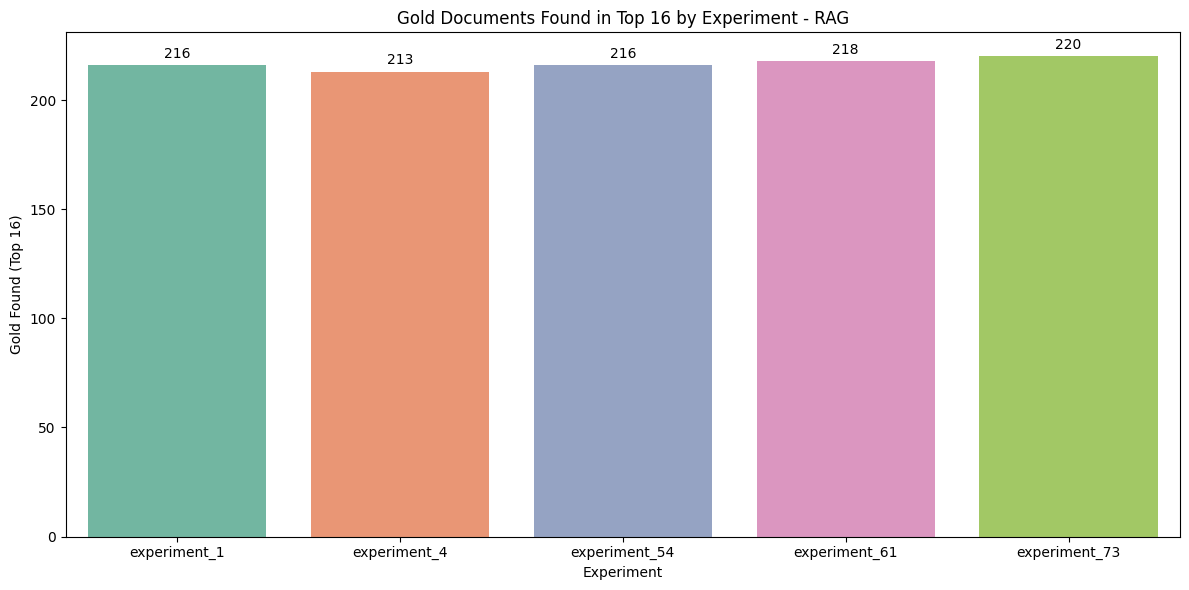

In [4]:

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=rag_gold_df, x="experiment", y="gold_found_top16", palette="Set2")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

plt.title("Gold Documents Found in Top 16 by Experiment - RAG")
plt.ylabel("Gold Found (Top 16)")
plt.xlabel("Experiment")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3545618/3863293080.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rag_gold_df, x="experiment", y="gold_found_total", palette="Set2")


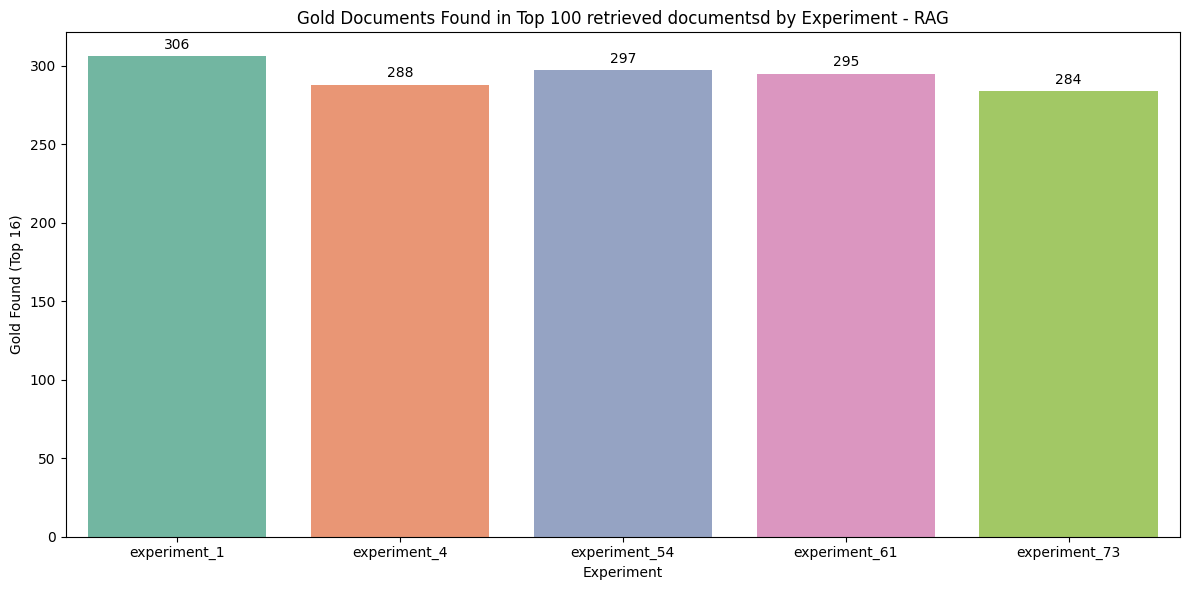

In [5]:

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=rag_gold_df, x="experiment", y="gold_found_total", palette="Set2")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

plt.title("Gold Documents Found in Top 100 retrieved documentsd by Experiment - RAG")
plt.ylabel("Gold Found (Top 16)")
plt.xlabel("Experiment")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3545618/679253116.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rag_gold_df, x="experiment", y="avg_gold_pos", palette="viridis")
/tmp/ipykernel_3545618/679253116.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Instruction")


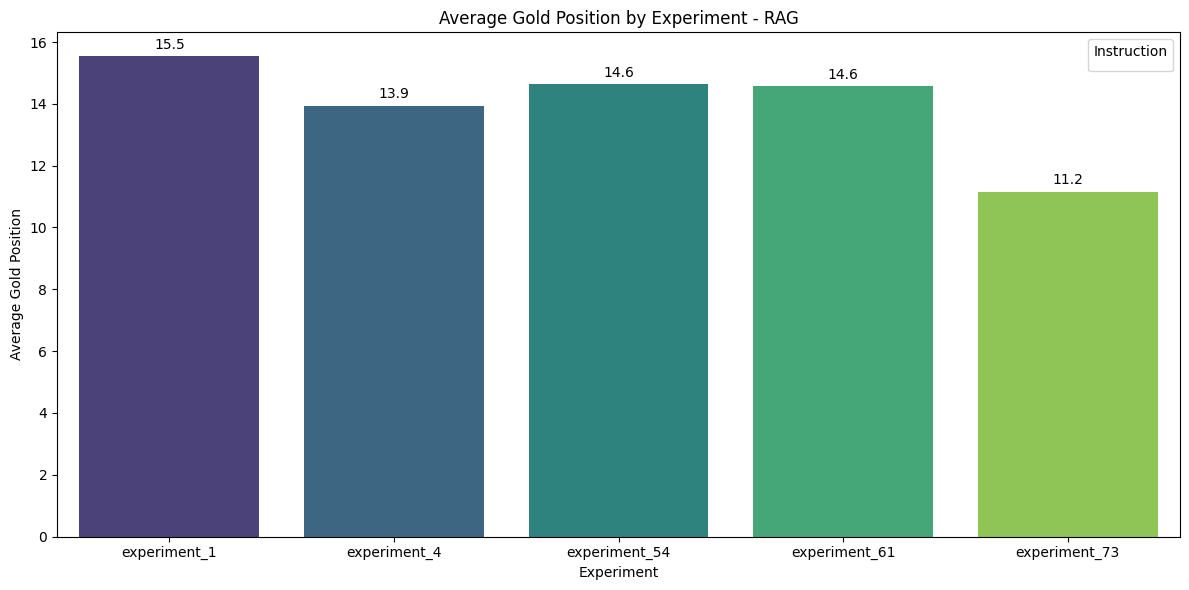

In [6]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=rag_gold_df, x="experiment", y="avg_gold_pos", palette="viridis")

# Add value labels on top of each bar with 1 decimal precision
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.title("Average Gold Position by Experiment - RAG")
plt.ylabel("Average Gold Position")
plt.xlabel("Experiment")
plt.legend(title="Instruction")
plt.tight_layout()
plt.show()

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


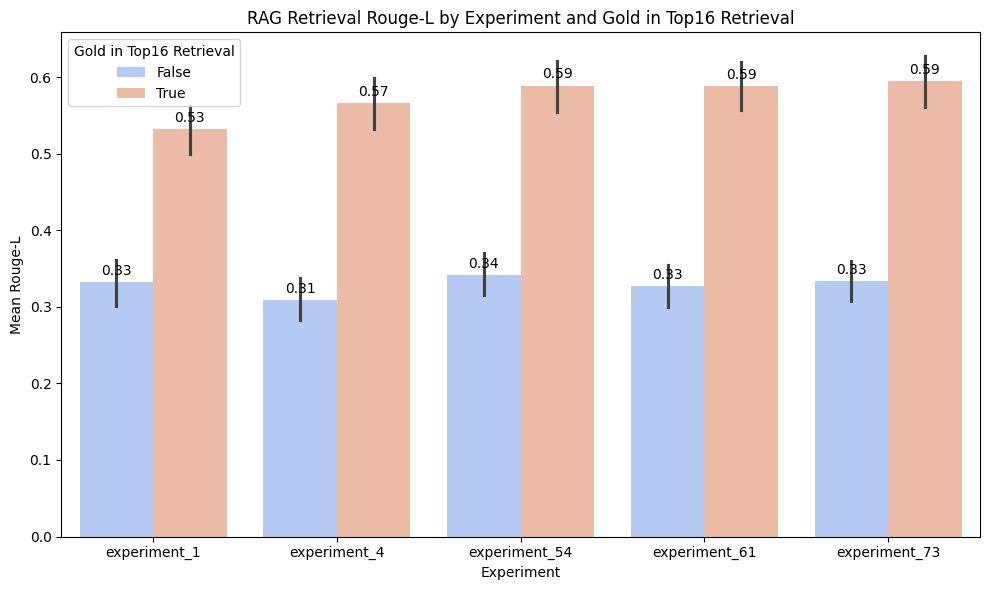

In [9]:
_tmp = rag_dfs_generations.clone()
filters = []

for exp in EXPERIMENTS:
        retrieval_path = f"{ROOT}/{exp}/instruction_1"
        questions_path = f"{ROOT}/{exp}/questions.feather"
        docs_to_retrieve = json.load(open(f"{retrieval_path}/retrieval/rag_retrieval_indexes.json", "r"))
        questions = pl.read_ipc(f"{questions_path}")

        q_idxs = questions[:500]["idx"].to_list()
        _gold_map = dict(zip(gold["idx"].to_list(), gold["idx_gold_in_corpus"].to_list()))
        _top16_map = {int(k): set(v[:16]) for k, v in docs_to_retrieve.items()}

        questions_with_gold_top16 = [
            i for i, q_idx in enumerate(q_idxs)
            if (_gold_map.get(q_idx) in _top16_map.get(i, set()))
        ]

        filters.extend(3*[True if i in questions_with_gold_top16 else False for i in range(500)])

_tmp = _tmp.with_columns(pl.Series("filter_top16_gold", filters))  


## Barplot agg by experiment with hue on "filter_top16_gold"
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=_tmp.to_pandas(), x="experiment", y="mean", hue="filter_top16_gold", palette="coolwarm")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title("RAG Retrieval Rouge-L by Experiment and Gold in Top16 Retrieval")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Experiment")
plt.legend(title="Gold in Top16 Retrieval")
plt.tight_layout()
plt.show()

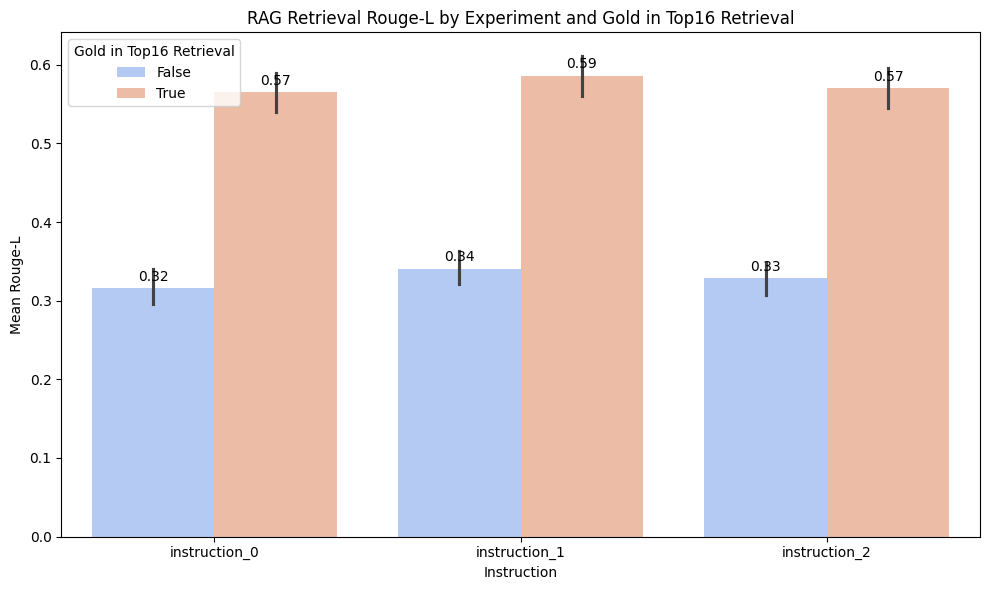

In [10]:
## Barplot agg by experiment with hue on "filter_top16_gold"
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=_tmp.to_pandas(), x="instruction", y="mean", hue="filter_top16_gold", palette="coolwarm")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title("RAG Retrieval Rouge-L by Experiment and Gold in Top16 Retrieval")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Gold in Top16 Retrieval")
plt.tight_layout()
plt.show()

## Datamodels Generation - Rouge-L Evaluator

In [2]:
LOAD = True
EXPERIMENTS = ["experiment_1", "experiment_4", "experiment_54", "experiment_61", "experiment_73"]
INSTRUCTIONS = ["instruction_0", "instruction_1", "instruction_2"]

if not LOAD:
    
    datamodels_dfs_generations = []
    for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
            questions_path = f"{ROOT}/{exp}/questions.feather"
            for file in os.listdir(f"{ROOT}/{exp}/{inst}/generations"):
                    if file.startswith("instruction") and file.endswith('Rouge-L.json'):
                        datamodels_dfs_generations.append(calculate_agg_metric(
                            metrics=["rouge_l"],
                            generation_path=f"{ROOT}/{exp}/{inst}/generations/{file}",
                            reference_path=questions_path    ,
                            saving_path=None            
                        )
                        .with_columns([
                            pl.lit(exp).alias("experiment"),
                            pl.lit(inst).alias("instruction")
                        ]))
                

    datamodels_dfs_generations = pl.concat(datamodels_dfs_generations)
    datamodels_dfs_generations.write_ipc(f"datamodels_rougel_dfs_generations.feather")        
else:
    datamodels_dfs_generations = pl.read_ipc(f"datamodels_rougel_dfs_generations.feather")

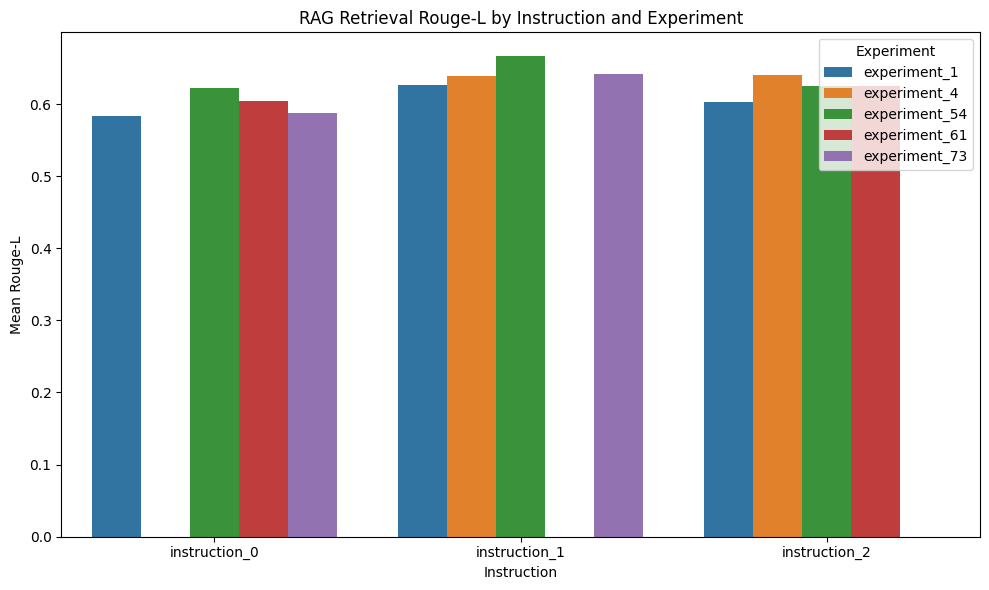

In [3]:
_rouge = datamodels_dfs_generations.group_by(["experiment", "instruction"]).agg(pl.mean("mean")).sort(["experiment", "instruction"])

## bar plot per instruction with hue by experiment
plt.figure(figsize=(10, 6))
sns.barplot(data=_rouge.to_pandas(), x="instruction", y="mean", hue="experiment")
plt.title("RAG Retrieval Rouge-L by Instruction and Experiment")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Experiment")
plt.tight_layout()
plt.show()

In [4]:
## Create dataframe with gold documents found for each experiment and instruction

gold_counts = []

for exp in EXPERIMENTS:
    for inst in INSTRUCTIONS:
        retrieval_path = f"{ROOT}/{exp}/{inst}"
        questions_path = f"{ROOT}/{exp}/questions.feather"
        try:
            docs_to_retrieve = json.load(open(f"{retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_indexes.json", "r"))
            questions = pl.read_ipc(f"{questions_path}")
            count16 = 0
            index_pos = []
            for i in range(500):
                gold_idx = gold.filter(pl.col("idx") == questions[i]["idx"].to_list()[0])["idx_gold_in_corpus"].to_list()[0]
                for idx in docs_to_retrieve[str(i)][85:]:
                    if idx == gold_idx:
                        count16+= 1
                for idx in docs_to_retrieve[str(i)]:
                    if idx == gold_idx:
                        index_pos.append(100 - docs_to_retrieve[str(i)].index(idx))

            gold_counts.append({
                "experiment": exp,
                "instruction": inst,
                "gold_found_top16": count16,
                "avg_gold_pos": np.array(index_pos).mean()
            })
        
        except:
            print(f"Document {retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_indexes.jso not found!!")

gold_df = pl.DataFrame(gold_counts)


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Document ../experiment_4/instruction_0/retrieval/instruction-0_experiment-4_evaluator-Rouge-L_indexes.jso not found!!


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Document ../experiment_61/instruction_1/retrieval/instruction-1_experiment-61_evaluator-Rouge-L_indexes.jso not found!!
Document ../experiment_73/instruction_2/retrieval/instruction-2_experiment-73_evaluator-Rouge-L_indexes.jso not found!!


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


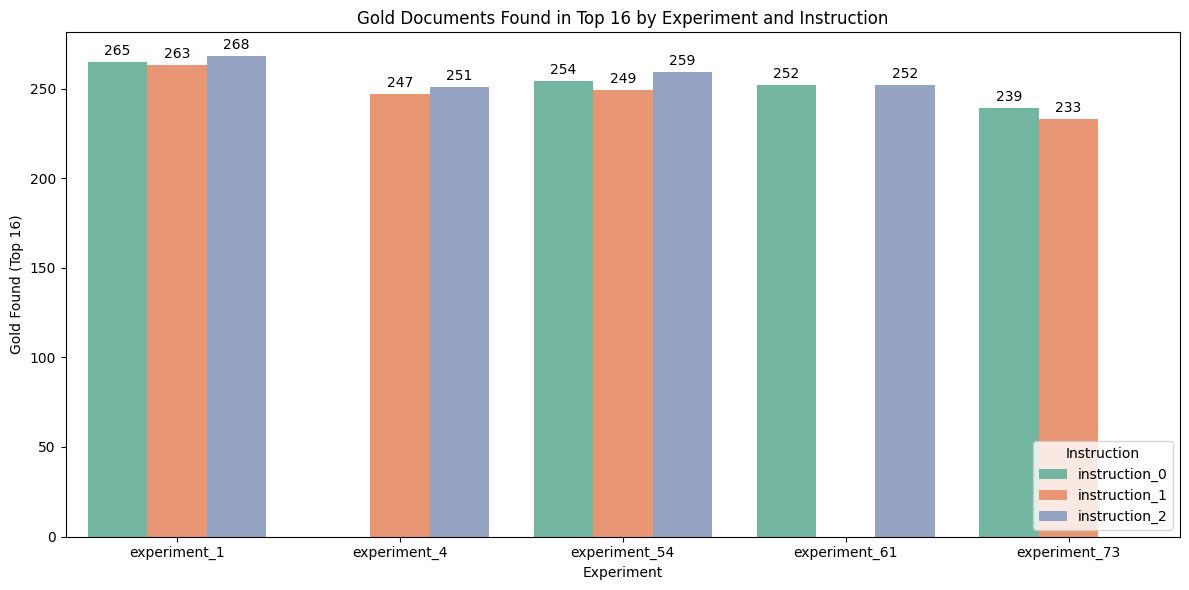

In [5]:

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=gold_df, x="experiment", y="gold_found_top16", hue="instruction", palette="Set2")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

plt.title("Gold Documents Found in Top 16 by Experiment and Instruction")
plt.ylabel("Gold Found (Top 16)")
plt.xlabel("Experiment")
plt.legend(title="Instruction")
plt.tight_layout()
plt.show()

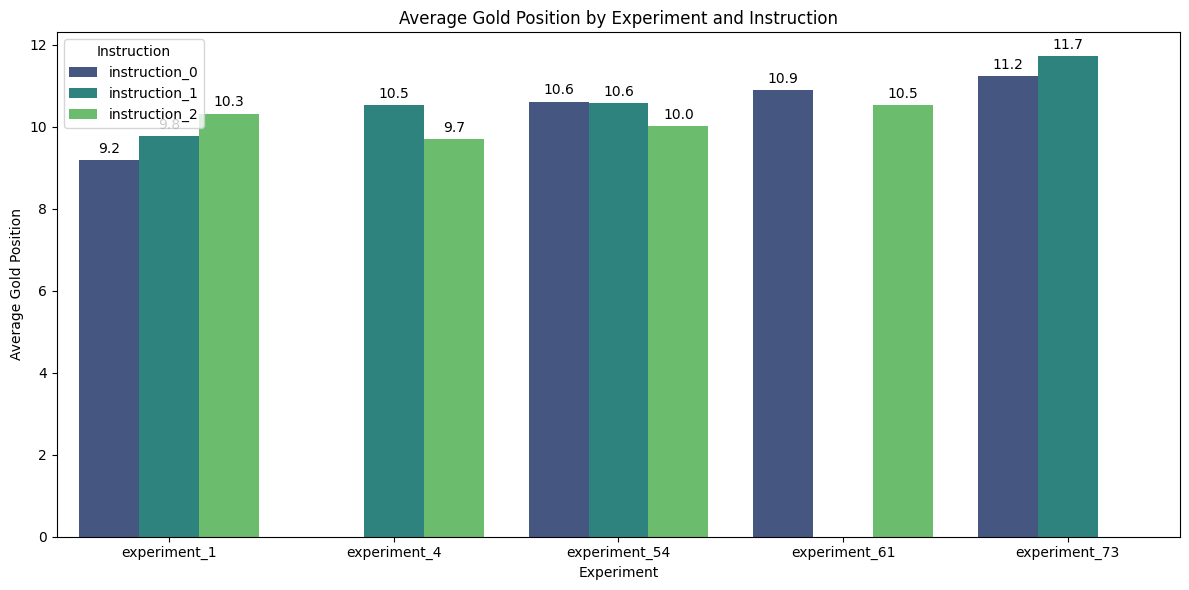

In [6]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=gold_df, x="experiment", y="avg_gold_pos", hue="instruction", palette="viridis")

# Add value labels on top of each bar with 1 decimal precision
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.title("Average Gold Position by Experiment and Instruction")
plt.ylabel("Average Gold Position")
plt.xlabel("Experiment")
plt.legend(title="Instruction")
plt.tight_layout()
plt.show()

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to 

Document ../experiment_4/instruction_0/retrieval/instruction-0_experiment-4_evaluator-Rouge-L_indexes.json not found!!
Document ../experiment_61/instruction_1/retrieval/instruction-1_experiment-61_evaluator-Rouge-L_indexes.json not found!!
Document ../experiment_73/instruction_2/retrieval/instruction-2_experiment-73_evaluator-Rouge-L_indexes.json not found!!


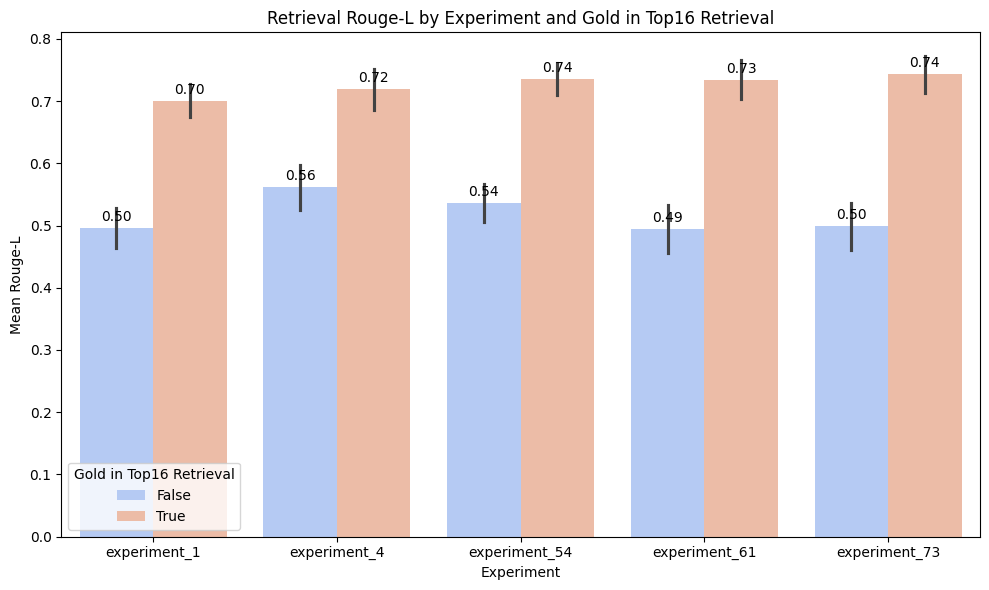

In [23]:
_tmp = datamodels_dfs_generations.clone()
filters = []

for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
            try:
                retrieval_path = f"{ROOT}/{exp}/{inst}"
                questions_path = f"{ROOT}/{exp}/questions.feather"
                docs_to_retrieve = json.load(open(f"{retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_indexes.json", "r"))
                questions = pl.read_ipc(f"{questions_path}")

                q_idxs = questions[:500]["idx"].to_list()
                _gold_map = dict(zip(gold["idx"].to_list(), gold["idx_gold_in_corpus"].to_list()))
                _top16_map = {int(k): set(v[84:]) for k, v in docs_to_retrieve.items()}

                questions_with_gold_top16 = [
                    i for i, q_idx in enumerate(q_idxs)
                    if (_gold_map.get(q_idx) in _top16_map.get(i, set()))
                ]

                filters.extend([True if i in questions_with_gold_top16 else False for i in range(500)])
            except:
                print(f"Document {retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_indexes.json not found!!")
            

_tmp = _tmp.with_columns(pl.Series("filter_top16_gold", filters))  


## Barplot agg by experiment with hue on "filter_top16_gold"
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=_tmp.to_pandas(), x="experiment", y="mean", hue="filter_top16_gold", palette="coolwarm")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title("Retrieval Rouge-L by Experiment and Gold in Top16 Retrieval")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Experiment")
plt.legend(title="Gold in Top16 Retrieval")
plt.tight_layout()
plt.show()

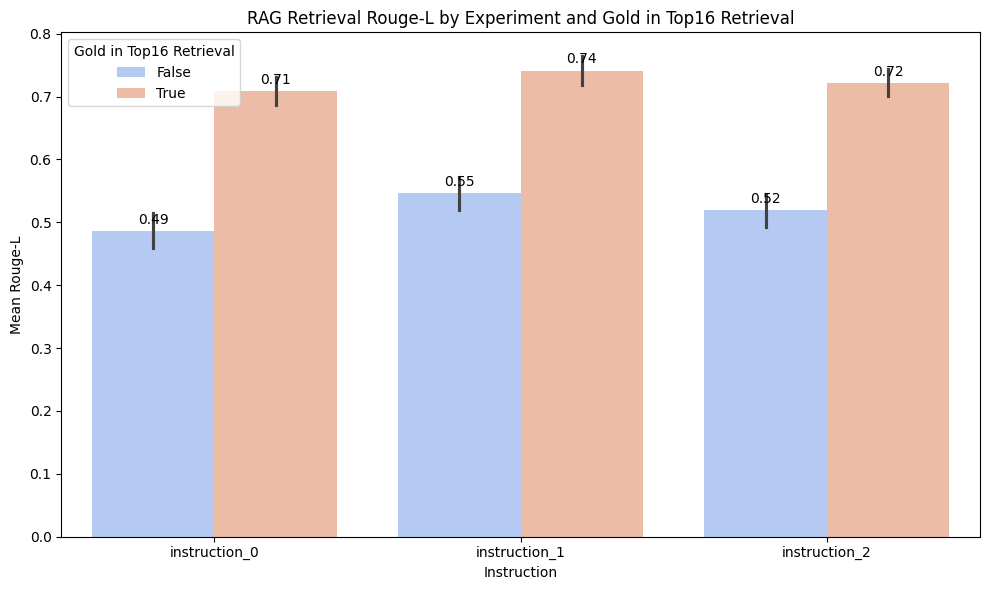

In [24]:
## Barplot agg by experiment with hue on "filter_top16_gold"
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=_tmp.to_pandas(), x="instruction", y="mean", hue="filter_top16_gold", palette="coolwarm")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title("RAG Retrieval Rouge-L by Experiment and Gold in Top16 Retrieval")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Gold in Top16 Retrieval")
plt.tight_layout()
plt.show()

In [15]:
f"{ROOT}/{exp}/{inst}/datamodels/"

'../experiment_4/instruction_0/datamodels/'

In [23]:
_tmp = datamodels_dfs_generations.clone()
mse = []
r2 = []

for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
                try:
                        ev_mse = pl.read_ipc(f"{ROOT}/{exp}/{inst}/datamodels/evaluations/evaluation_instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_mse.feather")
                        ev_r2 = pl.read_ipc(f"{ROOT}/{exp}/{inst}/datamodels/evaluations/evaluation_instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_R2Score.feather")
                        mse.extend(ev_mse["metric_mse"].to_list())
                        r2.extend(ev_r2["metric_R2Score"].to_list())
                except:
                        print("FIle not found!!")

evals = _tmp.with_columns(pl.Series("mse", mse))
evals = evals.with_columns(pl.Series("r2", r2))
evals.head()
                

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


FIle not found!!
FIle not found!!
FIle not found!!


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to 

idx,mean,max,metric,experiment,instruction,mse,r2
i64,f64,f64,str,str,str,f64,f64
0,1.0,1.0,"""rouge_l""","""experiment_1""","""instruction_0""",0.133668,-1.121715
1,0.571429,0.571429,"""rouge_l""","""experiment_1""","""instruction_0""",0.113099,-0.341722
2,1.0,1.0,"""rouge_l""","""experiment_1""","""instruction_0""",0.14456,-2.139619
3,1.0,1.0,"""rouge_l""","""experiment_1""","""instruction_0""",0.082319,-1.020047
4,1.0,1.0,"""rouge_l""","""experiment_1""","""instruction_0""",0.202888,-1.464937


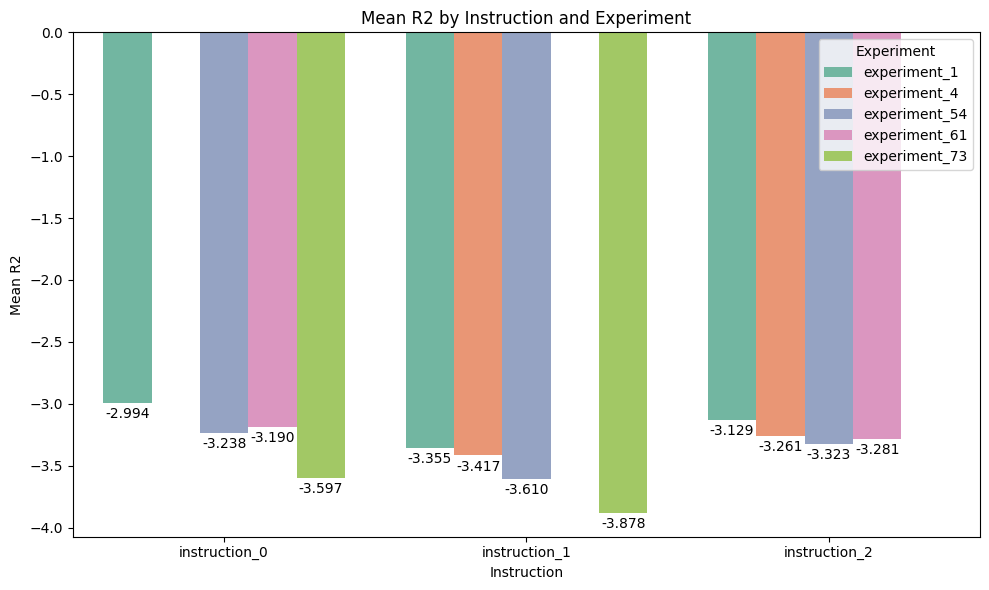

In [24]:
# Mean r2 by instruction and experiment
_agg = (
    evals
    .filter(pl.col("r2").is_not_null())
    .group_by(["experiment", "instruction"])
    .agg(pl.mean("r2").alias("mean_r2"))
    .sort(["experiment", "instruction"])
 )

if _agg.height == 0:
    print("No R2 data available for aggregation.")
else:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=_agg.to_pandas(), x="instruction", y="mean_r2", hue="experiment", palette="Set2")
    plt.title("Mean R2 by Instruction and Experiment")
    plt.ylabel("Mean R2")
    plt.xlabel("Instruction")
    plt.legend(title="Experiment")
    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    plt.tight_layout()
    plt.show()

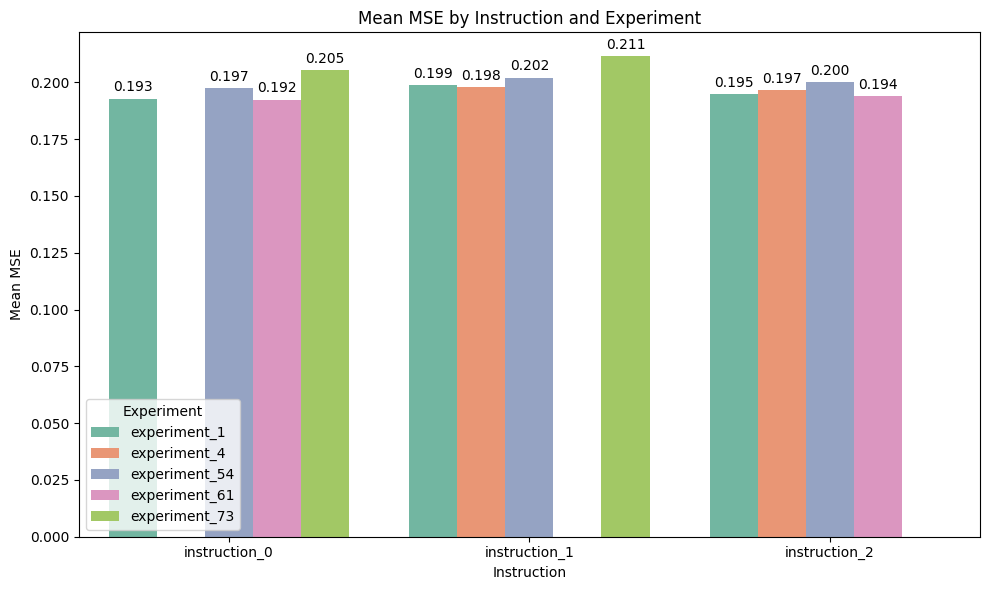

In [20]:
# Mean MSE by instruction and experiment
_agg = (
    evals
    .filter(pl.col("mse").is_not_null())
    .group_by(["experiment", "instruction"])
    .agg(pl.mean("mse").alias("mean_mse"))
    .sort(["experiment", "instruction"])
 )

if _agg.height == 0:
    print("No MSE data available for aggregation.")
else:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=_agg.to_pandas(), x="instruction", y="mean_mse", hue="experiment", palette="Set2")
    plt.title("Mean MSE by Instruction and Experiment")
    plt.ylabel("Mean MSE")
    plt.xlabel("Instruction")
    plt.legend(title="Experiment")
    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    plt.tight_layout()
    plt.show()

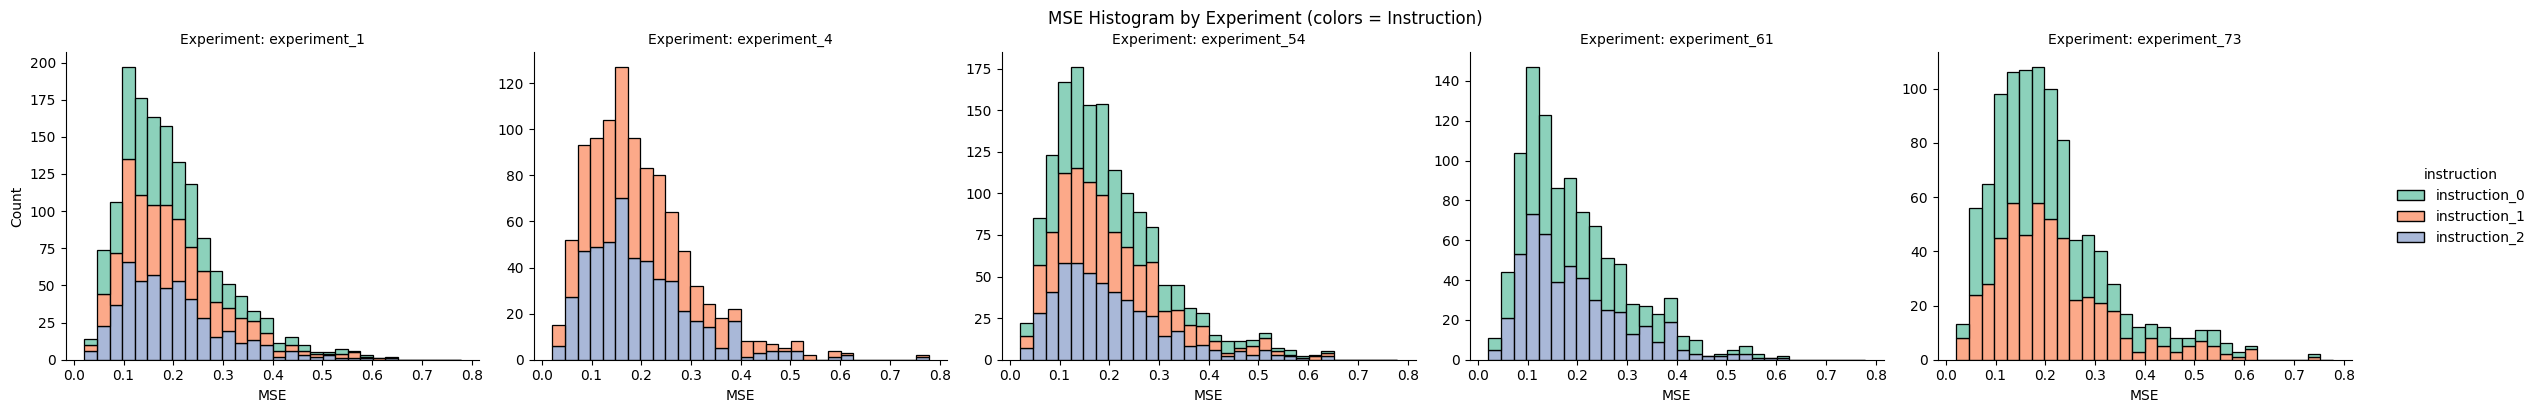

In [19]:
# Plot MSE histogram distribution by experiment with instruction as hue
# Converts Polars DataFrame to Pandas for seaborn plotting
_df = evals.filter(pl.col("mse").is_not_null()).to_pandas()

if _df.empty:
    print("No MSE data available to plot.")
else:
    # Facet by experiment, color by instruction
    g = sns.displot(
        data=_df,
        x="mse",
        hue="instruction",
        col="experiment",
        kind="hist",
        bins=30,
        multiple="stack",
        facet_kws={"sharex": False, "sharey": False},
        height=4,
        aspect=1.2,
        palette="Set2",
    )
    g.set_axis_labels("MSE", "Count")
    g.set_titles("Experiment: {col_name}")
    g.figure.suptitle("MSE Histogram by Experiment (colors = Instruction)", y=1.02)
    plt.show()

## Datamodels Generation - Judge Evaluator

In [25]:
LOAD = True
EXPERIMENTS = ["experiment_1", "experiment_4", "experiment_54", "experiment_61", "experiment_73"]
INSTRUCTIONS = ["instruction_0", "instruction_1", "instruction_2"]

if not LOAD:
    
    datamodels_dfs_generations = []
    for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
            questions_path = f"{ROOT}/{exp}/questions.feather"
            for file in os.listdir(f"{ROOT}/{exp}/{inst}/generations"):
                    if file.startswith("instruction") and file.endswith('Judge.json'):
                        datamodels_dfs_generations.append(calculate_agg_metric(
                            metrics=["rouge_l"],
                            generation_path=f"{ROOT}/{exp}/{inst}/generations/{file}",
                            reference_path=questions_path    ,
                            saving_path=None            
                        )
                        .with_columns([
                            pl.lit(exp).alias("experiment"),
                            pl.lit(inst).alias("instruction")
                        ]))
                

    datamodels_dfs_generations = pl.concat(datamodels_dfs_generations)
    datamodels_dfs_generations.write_ipc(f"datamodels_dfs_generations.feather")        
else:
    datamodels_dfs_generations = pl.read_ipc(f"datamodels_dfs_generations.feather")

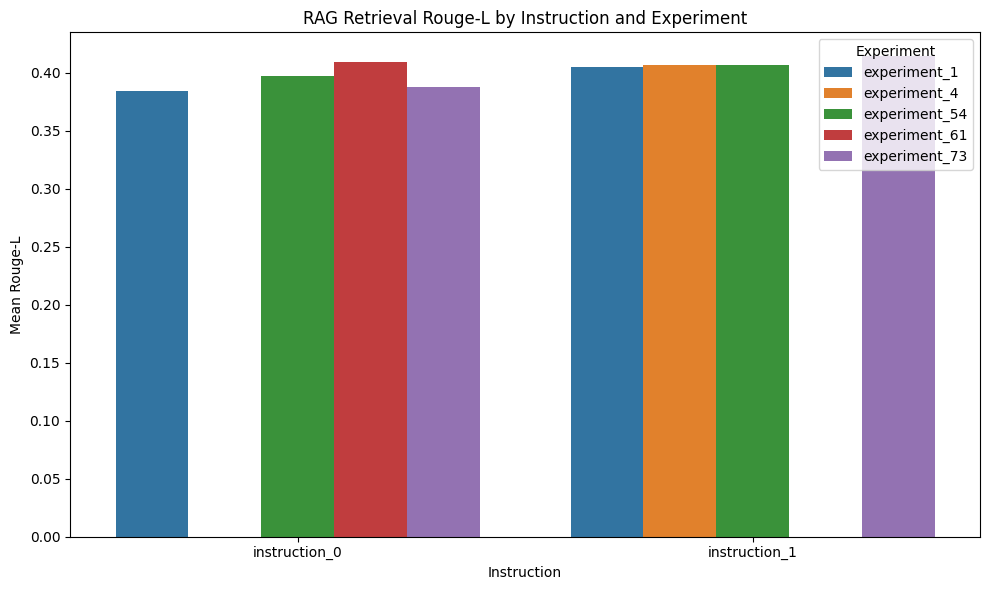

In [8]:

pl.Config.set_tbl_rows(15)
_dat = datamodels_dfs_generations.group_by(["experiment", "instruction"]).agg(pl.mean("mean")).sort(["experiment", "instruction"])
plt.figure(figsize=(10, 6))
sns.barplot(data=_dat.to_pandas(), x="instruction", y="mean", hue="experiment")
plt.title("RAG Retrieval Rouge-L by Instruction and Experiment")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Experiment")
plt.tight_layout()
plt.show()

In [9]:
gold_counts = []

for exp in EXPERIMENTS:
    for inst in INSTRUCTIONS:
        retrieval_path = f"{ROOT}/{exp}/{inst}"
        questions_path = f"{ROOT}/{exp}/questions.feather"
        try:
            docs_to_retrieve = json.load(open(f"{retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Judge_indexes.json", "r"))
            questions = pl.read_ipc(f"{questions_path}")
            count16 = 0
            index_pos = []
            for i in range(500):
                gold_idx = gold.filter(pl.col("idx") == questions[i]["idx"].to_list()[0])["idx_gold_in_corpus"].to_list()[0]
                for idx in docs_to_retrieve[str(i)][85:]:
                    if idx == gold_idx:
                        count16+= 1
                for idx in docs_to_retrieve[str(i)]:
                    if idx == gold_idx:
                        index_pos.append(100 - docs_to_retrieve[str(i)].index(idx))

            gold_counts.append({
                "experiment": exp,
                "instruction": inst,
                "gold_found_top16": count16,
                "avg_gold_pos": np.array(index_pos).mean()
            })
        
        except:
            print(f"Document {retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_indexes.jso not found!!")

gold_df = pl.DataFrame(gold_counts)

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Document ../experiment_1/instruction_2/retrieval/instruction-2_experiment-1_evaluator-Rouge-L_indexes.jso not found!!
Document ../experiment_4/instruction_0/retrieval/instruction-0_experiment-4_evaluator-Rouge-L_indexes.jso not found!!
Document ../experiment_4/instruction_2/retrieval/instruction-2_experiment-4_evaluator-Rouge-L_indexes.jso not found!!


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Document ../experiment_54/instruction_2/retrieval/instruction-2_experiment-54_evaluator-Rouge-L_indexes.jso not found!!
Document ../experiment_61/instruction_1/retrieval/instruction-1_experiment-61_evaluator-Rouge-L_indexes.jso not found!!
Document ../experiment_61/instruction_2/retrieval/instruction-2_experiment-61_evaluator-Rouge-L_indexes.jso not found!!
Document ../experiment_73/instruction_2/retrieval/instruction-2_experiment-73_evaluator-Rouge-L_indexes.jso not found!!


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


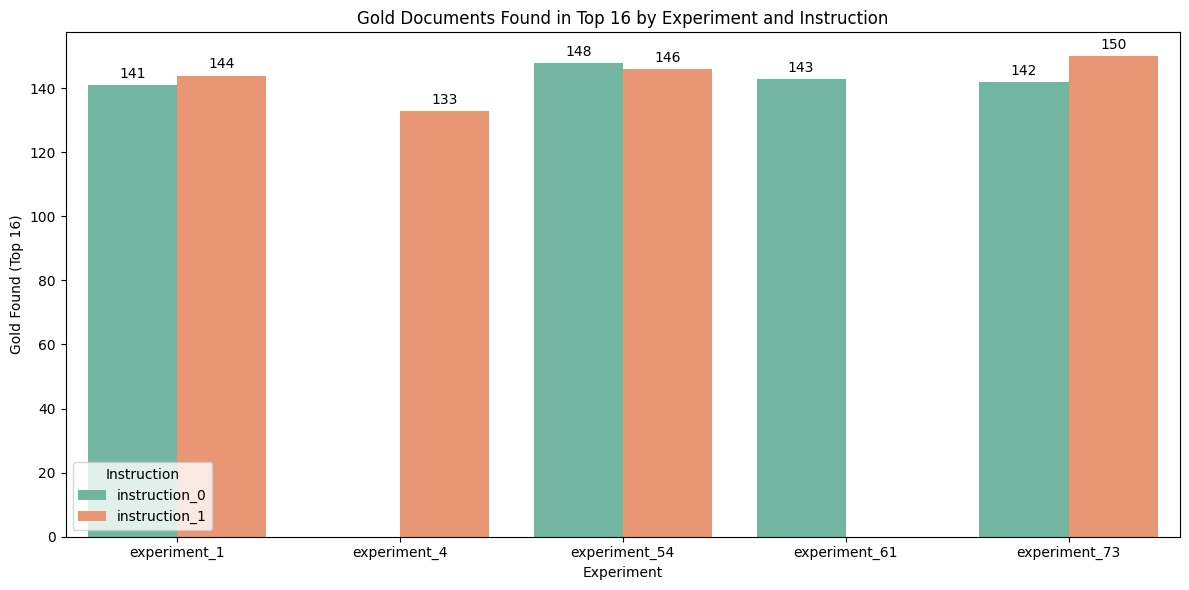

In [11]:

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=gold_df, x="experiment", y="gold_found_top16", hue="instruction", palette="Set2")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

plt.title("Gold Documents Found in Top 16 by Experiment and Instruction")
plt.ylabel("Gold Found (Top 16)")
plt.xlabel("Experiment")
plt.legend(title="Instruction")
plt.tight_layout()
plt.show()

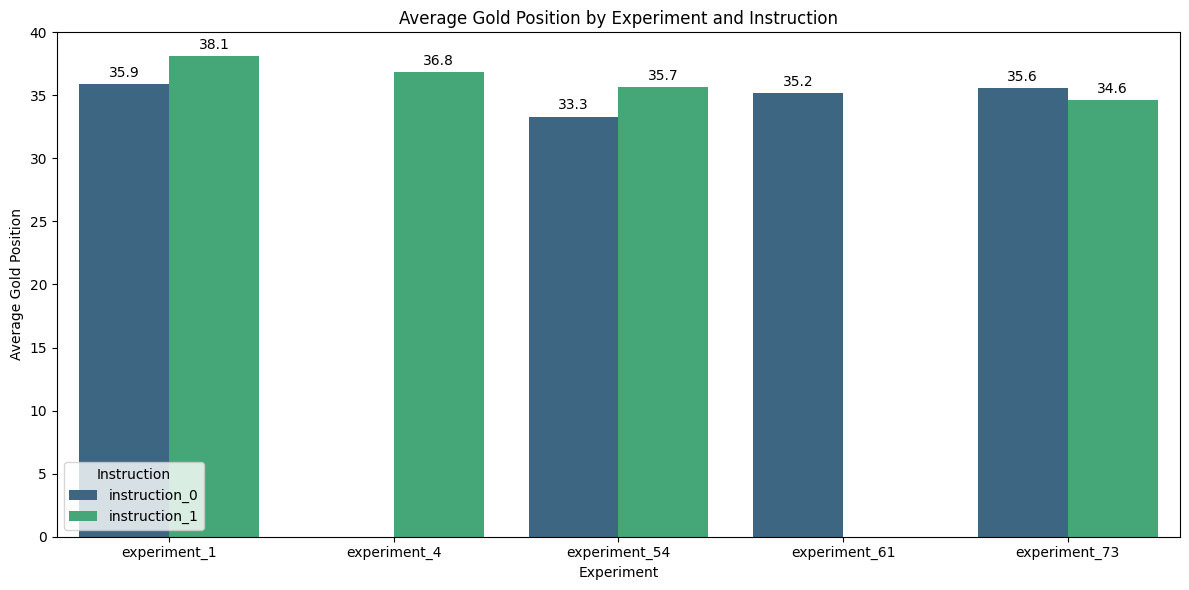

In [12]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=gold_df, x="experiment", y="avg_gold_pos", hue="instruction", palette="viridis")

# Add value labels on top of each bar with 1 decimal precision
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.title("Average Gold Position by Experiment and Instruction")
plt.ylabel("Average Gold Position")
plt.xlabel("Experiment")
plt.legend(title="Instruction")
plt.tight_layout()
plt.show()

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Document ../experiment_1/instruction_2/retrieval/instruction-2_experiment-1_evaluator-Rouge-L_indexes.json not found!!
Document ../experiment_4/instruction_0/retrieval/instruction-0_experiment-4_evaluator-Rouge-L_indexes.json not found!!
Document ../experiment_4/instruction_2/retrieval/instruction-2_experiment-4_evaluator-Rouge-L_indexes.json not found!!
Document ../experiment_54/instruction_2/retrieval/instruction-2_experiment-54_evaluator-Rouge-L_indexes.json not found!!


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Document ../experiment_61/instruction_1/retrieval/instruction-1_experiment-61_evaluator-Rouge-L_indexes.json not found!!
Document ../experiment_61/instruction_2/retrieval/instruction-2_experiment-61_evaluator-Rouge-L_indexes.json not found!!
Document ../experiment_73/instruction_2/retrieval/instruction-2_experiment-73_evaluator-Rouge-L_indexes.json not found!!


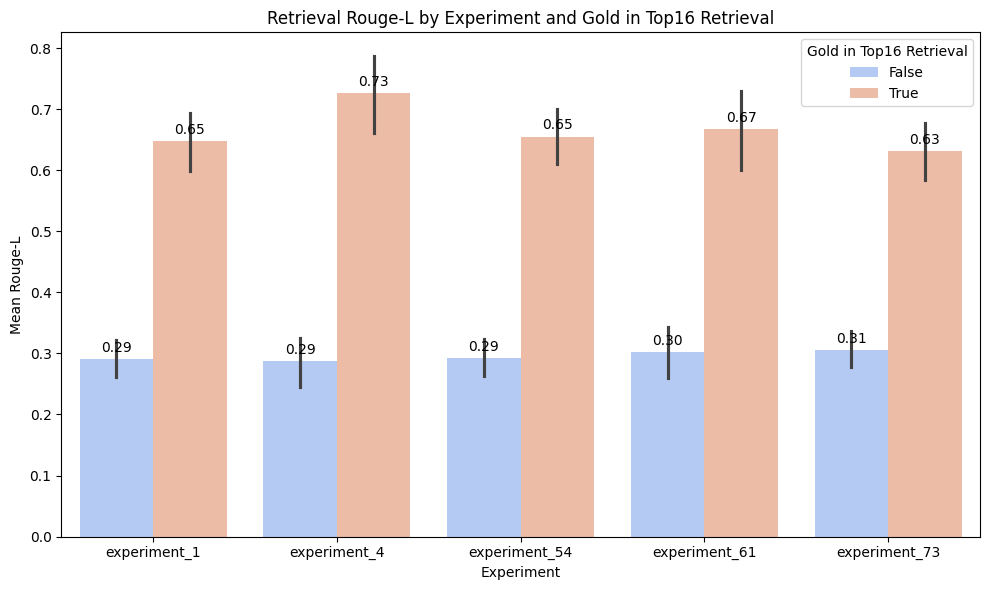

In [26]:
_tmp = datamodels_dfs_generations.clone()
filters = []

for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
            try:
                retrieval_path = f"{ROOT}/{exp}/{inst}"
                questions_path = f"{ROOT}/{exp}/questions.feather"
                docs_to_retrieve = json.load(open(f"{retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Judge_indexes.json", "r"))
                questions = pl.read_ipc(f"{questions_path}")

                q_idxs = questions[:500]["idx"].to_list()
                _gold_map = dict(zip(gold["idx"].to_list(), gold["idx_gold_in_corpus"].to_list()))
                _top16_map = {int(k): set(v[84:]) for k, v in docs_to_retrieve.items()}

                questions_with_gold_top16 = [
                    i for i, q_idx in enumerate(q_idxs)
                    if (_gold_map.get(q_idx) in _top16_map.get(i, set()))
                ]

                filters.extend([True if i in questions_with_gold_top16 else False for i in range(500)])
            except:
                print(f"Document {retrieval_path}/retrieval/instruction-{inst.split('_')[1]}_experiment-{exp.split('_')[1]}_evaluator-Rouge-L_indexes.json not found!!")
            

_tmp = _tmp.with_columns(pl.Series("filter_top16_gold", filters))  


## Barplot agg by experiment with hue on "filter_top16_gold"
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=_tmp.to_pandas(), x="experiment", y="mean", hue="filter_top16_gold", palette="coolwarm")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title("Retrieval Rouge-L by Experiment and Gold in Top16 Retrieval")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Experiment")
plt.legend(title="Gold in Top16 Retrieval")
plt.tight_layout()
plt.show()

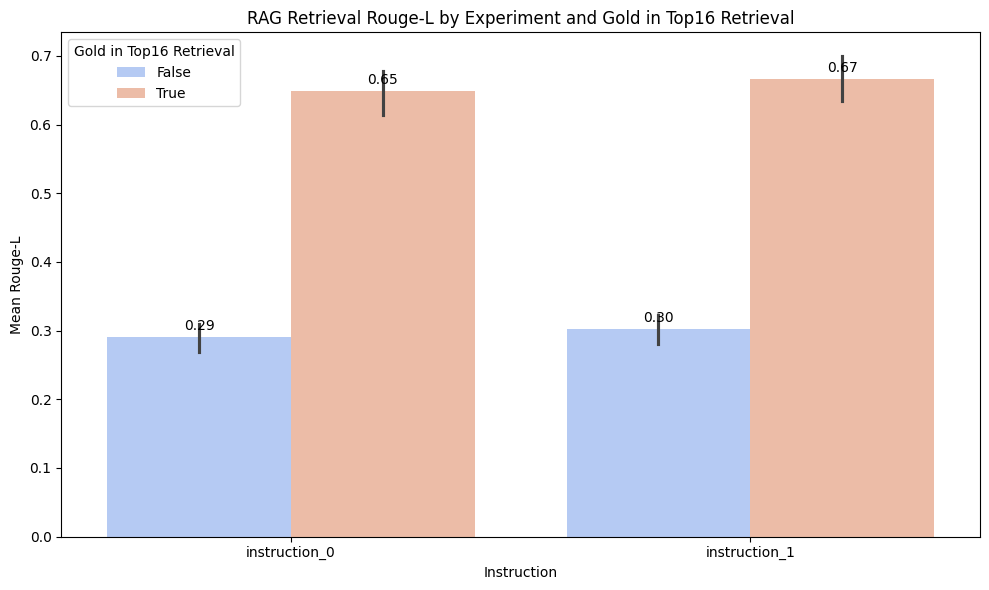

In [27]:
## Barplot agg by experiment with hue on "filter_top16_gold"
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=_tmp.to_pandas(), x="instruction", y="mean", hue="filter_top16_gold", palette="coolwarm")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title("RAG Retrieval Rouge-L by Experiment and Gold in Top16 Retrieval")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Gold in Top16 Retrieval")
plt.tight_layout()
plt.show()